# Loopy Belief Propagation for Image Denoising

### Import Required Libraries

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

### Functions to generate a clean image and add artificial noise
##### A binary image of a circle of given radies within a rectangle of given dimensions is generated. Noise is added by flipping the values of every pixel with a specified probability. Higher the flip probability, higher the amount of noise in the image 

In [2]:
def generate_clean_image(size, radius):
    ''' Generates a binary circle image of given radius within a rectangle of given size
    # ARGUMENTS
    # ========= 
    # size (list or np array): size of rectangle 
    # radius (float): radius of circle '''
    if len(size)!=2:
        throw('Size must be of shape 2x1 or 1x2')
    img = np.zeros(size)
    center = np.array([0.5*(size[0]-1), 0.5*(size[1]-1)])
    for i in range(size[0]):
        for j in range(size[1]):
            d = np.linalg.norm(np.array([i,j]) - np.array(center))
            if d <= radius:
                img[i][j] = 1        
    return img


def add_noise(img, flip_prob):
    ''' Adds noise to a given binary image. Value of each pixel is flipped with given probability
    # ARGUMENTS
    # =========
    # img (numpy array): image to which noise is to be added
    # flip_prob (float \in [0,1]): probability with which each pixel value is flipped
    '''
    img_noisy = np.copy(img)
    for i in range(img_noisy.shape[0]):
        for j in range(img_noisy.shape[1]):
            if np.random.rand() <= flip_prob:
                img_noisy[i][j] = 1 - img[i][j]
    return img_noisy

### Main Code - Creates the "LoopyBPImageDenoiser" class to denoise a binary image

##### The underlying graphical model is as follows:
##### The observed(noisy) value of every pixel depends on both the true(without noise) value of the pixel as well as the values of the neighboring pixels. Using this assumptions a graphical model is constructed. Loopy Belief propagation is implemented on the Bethe Cluster Graph corresponding to this graph. 

In [3]:
class LoopyBPImageDenoiser():
    def __init__(self):
        pass
 
    def show_input(self):
        plt.imshow(self.img_in)
        
    def init_bethe_CG(self):
        self.init_nodes()
        self.init_node_potentials()
        self.init_edge_potentials()
        
    def init_nodes(self):
        '''Initialize Cluster Graph Node Names'''
        self.x_nodes = []
        self.y_nodes = []
        self.yx_nodes = []
        self.xx_nodes = []
        
        m = self.img_in.shape[0]
        n = self.img_in.shape[1]
        
        self.m = m
        self.n = n
        
        for i in range(m):
            for j in range(n):                    
                self.x_nodes.append('x' + str(i) + '.' + str(j))
                self.y_nodes.append('y' + str(i) + '.' + str(j))
                self.yx_nodes.append('y' + str(i) + '.' + str(j) + '_x' + str(i) + '.' + str(j))
                if i!=m-1:
                    self.xx_nodes.append('x' + str(i) + '.' + str(j) + '_x' + str(i+1) + '.' + str(j))
                if j!=n-1:
                    self.xx_nodes.append('x' + str(i) + '.' + str(j) + '_x' + str(i) + '.' + str(j+1))

                    
 
    def init_node_potentials(self):
        '''Initialize Cluster Graph Node Potentials as a dictionary'''
        self.node_potentials = {}
        for node in self.y_nodes:
            i, j = node[1:].split('.')
            pixel_val = self.img_in[int(i)][int(j)]
            node_potential = [abs(0.95 - pixel_val), abs(0.05 - pixel_val)]
            self.node_potentials[node] = np.array(node_potential)
            
        for node in self.x_nodes:
            node_potential = np.ones(2)
            self.node_potentials[node] = node_potential
            
        for node in self.xx_nodes:
            var1, var2 = node.split('_')
            node_potential = [[1 + self.theta, 1 - self.theta], [1 - self.theta, 1 + self.theta]]
            self.node_potentials[node] = np.array(node_potential)
        
        for node in self.yx_nodes:
            node_potential = [[1 + self.gamma, 1 - self.gamma], [1 - self.gamma, 1 + self.gamma]]
            self.node_potentials[node] = np.array(node_potential)
                        
                        
    def init_edge_potentials(self):
        '''Initialize Cluster Graph Edge Potentials as a defaultdict'''
        self.edge_potentials = defaultdict(lambda:np.ones(2))
        
    def denoise(self, img_in, theta, gamma, n_iters=3):
        self.gamma = gamma
        self.theta = theta
        self.img_in = img_in
        self.init_bethe_CG()
        for i in tqdm(range(n_iters)):
            self.single_pass()
        self.img_out = np.ones([m, n])
        for i in range(m):
            for j in range(n):
                key = 'x' + str(i) + '.' + str(j)
                self.img_out[i][j] = np.argmax(denoiser.node_potentials[key])
        return self.img_out
    
    def single_pass(self, verbose=False):
        for node in self.y_nodes:
            x_node = 'x' + node[1:]
            target_node = node + '_' + x_node
            self.send_message(node, target_node, verbose)
            
        for node in self.yx_nodes:
            target_node = node.split('_')[1]
            self.send_message(node, target_node, verbose)
            
        for node in self.x_nodes:
            i,j = node[1:].split('.')
            rnode = 'x' + i + '.' + str(int(j) + 1)
            lnode = 'x' + i + '.' + str(int(j) - 1)
            unode = 'x' + str(int(i) - 1) + '.' + j
            dnode = 'x' + str(int(i) + 1) + '.' + j
            
            if int(j) + 1 < self.m:
                target_node = node + '_' + rnode
                self.send_message(node, target_node, verbose)
            if int(j) - 1 >= 0:
                target_node =  lnode + '_'+ node
                self.send_message(node, target_node, verbose)
            if int(i) - 1>= 0:
                target_node = unode + '_' + node
                self.send_message(node, target_node, verbose)
            if int(i) + 1 < self.n:
                target_node = node + '_' + dnode  
                self.send_message(node, target_node, verbose)

        for node in self.xx_nodes:
            var1, var2 = node.split('_')
            self.send_message(node, var1, verbose)
            self.send_message(node, var2, verbose)
        
#         self.normalize()
        
    def normalize(self):
        m = self.m
        n = self.n
        n_nodes = 3*m*n + m*(n-1) + n*(m-1)
        normalizing_factor = 0
        for node in self.x_nodes:
            normalizing_factor += self.node_potentials[node].sum()
        for node in self.y_nodes:
            normalizing_factor += self.node_potentials[node].sum()
        for node in self.yx_nodes:
            normalizing_factor += self.node_potentials[node].sum()
        for node in self.xx_nodes:
            normalizing_factor += self.node_potentials[node].sum()
        
        normalizing_factor = normalizing_factor/n_nodes
        print('\nNormalizing Factor = ', normalizing_factor)
        
        for node in self.x_nodes:
            self.node_potentials[node] *= 1/normalizing_factor
        for node in self.y_nodes:
            self.node_potentials[node] *= 1/normalizing_factor
        for node in self.yx_nodes:
            self.node_potentials[node] *= 1/normalizing_factor
        for node in self.xx_nodes:
            self.node_potentials[node] *= 1/normalizing_factor
                
                
    def send_message(self, node1, node2, verbose=False):
        if not '_' in node1:
            sigma = self.node_potentials[node1]
        else:
            var1, var2 = node1.split('_')
            if node2 == var1:
                sigma = self.max_marginalize(node1, var2 )
            elif node2 == var2:
                sigma = self.max_marginalize(node1, var1)
        edge = node1 + node2
        initial_edge_potential = self.edge_potentials[edge]
        message = self.factor_div(sigma, self.edge_potentials[edge])
        initial_potential = self.node_potentials[node2]
        orientation = self.is_edge(node1, node2)
        self.node_potentials[node2] = self.factor_prod(message, self.node_potentials[node2], orientation)
        final_potential = self.node_potentials[node2]
        self.edge_potentials[edge] = sigma
        final_edge_potential = self.edge_potentials[edge]
        if verbose:
            print('\nmessage from: ', node1, '-->', node2)
            print('---------------------------------------')
            print('\nsigma: ', sigma)
            print('\nedge_potential = ', initial_edge_potential)
            print('\nmessage', node1,'-', node2,' = ', sigma, '/', initial_edge_potential, ' = ', message)
            print('\nInitial', node2, 'potential: ', initial_potential)
            print('\nFinal', node2, 'potential: ', final_potential)

    
    def is_edge(self, node1, node2):
        if '_' in node1:
            sep_set = node2
            l = len(node1)
            var1, var2 = node1.split('_')
        else:
            sep_set = node1
            var1, var2 = node2.split('_')
            
        if sep_set == var1:
            return -1
        elif sep_set == var2:
            return 1
        else:
            return 0
            
        
    def max_marginalize(self, node, var):
        ''' 'Max Marginalize' the node_potential of the input node over the input variable ''' 
        
        variables = node.split('_')
        if var == variables[0]:
            axis = 0
#             print('\nMarginalize Node Potential: ',node, ' ', self.node_potentials[node], ' on axis ', axis)
            return np.max(self.node_potentials[node], axis=axis)
        elif var == variables[1]:
            axis = 1
#             print('\nMarginalize Node Potential: ', node, ' ', self.node_potentials[node], ' on axis ', axis)
            return np.max(self.node_potentials[node], axis=axis)
        
    def factor_prod(self, f1, f2, orientation):
        if orientation==-1:
            return f1*f2
        elif orientation==1:
            return (f1*f2.T).T
         
    def factor_div(self, f1, f2):
        '''
        Divide factor f1 by factor f2
        
        Arguments:
        =========
        f1 (np.ndarray): Dividend
        f2 (np.ndarray): Divisor
        
        Constraints:
        f1.shape = (n,) , n \in N
        f2.shape = (n,)
        f2[i]=0 ==> f1[i]=0 \forall i in n
        '''
        f1_c = np.copy(f1)
        f2_c = np.copy(f2)
        for i in range(len(f2)):
            if f2[i] == 0:
                f2_c[i] = 1
                if f1[i] > 0:
                    print(f1[i],'/0 ','encountered')
                else:
                    f1_c[i] = 1                    
        return f1_c/f2_c
    
    def compare_with_original(self, target_img):
        ''' 
        Compare how close the output denoised image is to the target image. 
        Returns number of pixels where target image values differ from output image 
        
        Arguments:
        =========
        target_img (np.ndarray, mxn): Target Image 
        
        '''
        diff = np.sum(np.square(target_img - self.img_out))
        return diff
        

In [4]:
m = 100
n = 100
radius = 25
img_in = generate_clean_image([m,n],radius)
gamma = 0.2
theta = 0.1

img_noisy1 = add_noise(img_in, flip_prob=0.1)
img_noisy2 = add_noise(img_in, flip_prob=0.2)
img_noisy3 = add_noise(img_in, flip_prob=0.3)

denoiser = LoopyBPImageDenoiser()
img_out1 = denoiser.denoise(img_noisy1, gamma, theta)
img_out2 = denoiser.denoise(img_noisy2, gamma, theta)
img_out3 = denoiser.denoise(img_noisy3, gamma, theta)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.04s/it]


### Results

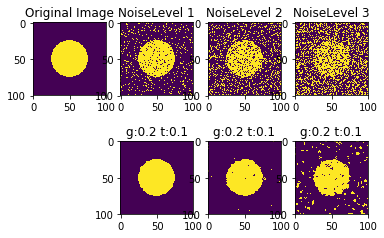

In [5]:
t = 'g:' + str(gamma) + ' t:' + str(theta)
plt.subplot(2,4,1)
plt.imshow(img_in)
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(img_noisy1)
plt.title('NoiseLevel 1')
plt.subplot(2,4,3)
plt.imshow(img_noisy2)
plt.title('NoiseLevel 2')
plt.subplot(2,4,4)
plt.imshow(img_noisy3)
plt.title('NoiseLevel 3')
plt.subplot(2,4,6)
plt.title(t)
plt.imshow(img_out1)
plt.subplot(2,4,7)
plt.title(t)
plt.imshow(img_out2)
plt.subplot(2,4,8)
plt.title(t)
plt.imshow(img_out3)